- References  
    [Global Wheat Detection - EDA](https://www.kaggle.com/pestipeti/global-wheat-detection-eda)

In [131]:
import numpy as np
import pandas as pd
import cv2
import re
from tqdm.notebook import tqdm
from PIL import Image
import hashlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN_IMAGES = f'{DIR_INPUT}/train'

In [132]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [133]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


# image meta

- [pandasでユニークな要素の個数、頻度（出現回数）をカウント](https://note.nkmk.me/python-pandas-value-counts/)

In [134]:
# ユニーク数とその中身の確認
print('<image_id>\n', train_df['image_id'].nunique())
print('<width>\n', train_df['width'].value_counts())
print('<height>\n',train_df['height'].value_counts())
print('<source>\n',train_df['source'].value_counts())

<image_id>
 3373
<width>
 1024    147793
Name: width, dtype: int64
<height>
 1024    147793
Name: height, dtype: int64
<source>
 ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64


- [hashlib md5やsha256などのハッシュ値を生成する](https://www.python.ambitious-engineer.com/archives/1069)  

- [update() を用いて任意の文字列を渡す](https://docs.python.org/ja/2.7/library/hashlib.html#module-hashlib)  

- [ndarray.tostring(order='C')](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.tostring.html#numpy-ndarray-tostring)  

- [hash.hexdigest()](https://docs.python.org/ja/2.7/library/hashlib.html#hashlib.hash.hexdigest)

- [Pythonの画像処理ライブラリPillow(PIL)の使い方](https://note.nkmk.me/python-pillow-basic/)

- [Pythonで画像の大きさやフォーマットを調べる（Pillow編）](https://water2litter.net/rum/post/python_pil_image_attributes/#my_mokuji1)

In [135]:
def calculate_hash(im):
    # ハッシュ値生成インスタンス
    md5 = hashlib.md5()
    # updateで任意の文字列を渡す
    md5.update(np.array(im).tostring())
    
    # 戻り値：hash値
    return md5.hexdigest()

def get_image_meta(image_id, image_src, dataset='train'):
    # Pillowで画像データを開く
    im = Image.open(image_src)
    # RGB各色の最小値と最大値を取得する
    extrema = im.getextrema()
    
    meta = {
        'image_id': image_id,
        'dataset': dataset,
        'hash': calculate_hash(im),
        'r_min': extrema[0][0],
        'r_max': extrema[0][1],
        'g_min': extrema[1][0],
        'g_max': extrema[1][1],
        'b_min': extrema[2][0],
        'b_max': extrema[2][1],
        'height': im.size[0],
        'width': im.size[1],
        'format': im.format,
        'mode': im.mode
    }
    return meta

In [136]:
data = []


for i, image_id in enumerate(tqdm(train_df['image_id'].unique(), total=train_df['image_id'].unique().shape[0])):
    data.append(get_image_meta(image_id, DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_id)))

In [137]:
meta_df = pd.DataFrame(data)
meta_df.head()

,image_id,dataset,hash,r_min,r_max,g_min,g_max,b_min,b_max,height,width,format,mode
0,b6ab77fd7,train,d419a31c10d0049435031874ed475ec4,1,255,0,255,0,255,1024,1024,JPEG,RGB
1,b53afdf5c,train,653d2477b415eded51cfa8cc2e7d9aea,4,255,7,255,0,255,1024,1024,JPEG,RGB
2,7b72ea0fb,train,5299cf14bb0108ac2c6975230187f5e9,0,255,0,255,0,255,1024,1024,JPEG,RGB
3,91c9d9c38,train,63cc5dd3e1fb4751ecb0a51f09a3c3b5,0,255,4,255,0,255,1024,1024,JPEG,RGB
4,41c0123cc,train,83e3ce0549d4a104d5e4159da234c17f,0,255,0,255,0,255,1024,1024,JPEG,RGB


# Duplications

In [138]:
# 重複の確認
duplicates = meta_df.groupby(by='hash')[['image_id']].count().reset_index()
duplicates

,hash,image_id
0,00011a26d3fcb4a4b17ba560b704db45,1
1,0006a007d26c737dd815931d1f001b2c,1
2,00160f2261a1d57ccadcc0c43516b0c5,1
3,0021ad1141b96508ec00add0c0afca14,1
4,002361e68af40e15f6d7d04912d100cd,1
...,...,...
3368,ffc9993aed6fe83d5c691ecb8b5aefb5,1
3369,ffd807775afa1ee5d4d3d20fb3513d2d,1
3370,ffd8d5a804483642552e387431048d56,1
3371,ffda7c7da7bc1102bd416d834aef26ae,1


- [PandasでIndexをリセットするreset_index関数の使い方](https://deepage.net/features/pandas-reset-index.html)

In [139]:
duplicates = duplicates[duplicates['image_id'] > 1]
duplicates.reset_index(drop=True, inplace=True)
duplicates

,hash,image_id


In [140]:
duplicates = duplicates.merge(meta_df[['image_id', 'hash']], on = 'hash')
duplicates.head()

,image_id_x,image_id_y,hash


# Extract bounding box data

- [基本的な正規表現一覧](https://murashun.jp/blog/20190215-01.html)

In [141]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall('([0-9]+[.]?[0-9]*)', x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0


In [142]:
train_df.drop(columns=['bbox'], inplace=True)
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [143]:
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


# source

In [144]:
# image_idごとのsource数をカウントし、最大値と最小値と平均値を表示
train_df.groupby(by='image_id')['source'].count().agg(['min', 'max', 'mean'])

min       1.000000
max     116.000000
mean     43.816484
Name: source, dtype: float64

In [145]:
source = train_df['source'].value_counts()
source

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [146]:
fig = go.Figure(data=[go.Pie(labels=source.index, values=source.values)])

fig.update_layout(title='Source distribution')
fig.show()

# show images

- [matplotlibの描画の基本 - figやらaxesやらがよくわからなくなった人向け](https://qiita.com/kenichiro_nishioka/items/8e307e164a4e0a279734)

- [配列を1次元に変換するNumPyのflatten関数の使い方](https://deepage.net/features/numpy-flatten.html)

- [Matplotlib でサブプロットの軸をオフにする方法](https://www.delftstack.com/ja/howto/matplotlib/how-to-turn-off-the-axes-for-subplots-in-matplotlib/)

- [matplotlib - imshow で画像や配列を表示する方法](https://www.pynote.info/entry/matplotlib-imshow)

In [159]:
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()
    
    for i, image_id in enumerate(image_ids):
        image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax[i].set_axis_off() # aubplotsの軸表示をオフにする
        ax[i].imshow(image) 
        ax[i].set_title(image_id)

- [Python, OpenCVで画像ファイルの読み込み、保存（imread, imwrite）](https://note.nkmk.me/python-opencv-imread-imwrite/)  
    カラー画像のファイルを読み込むと、行（高さ） x 列（幅） x 色（3）の三次元のndarrayとなる。  
    色の順番はRGBではなくBGR。

- [Python, OpenCVでBGRとRGBを変換するcvtColor](https://note.nkmk.me/python-opencv-bgr-rgb-cvtcolor/)  
    
- [pandas.DataFrameのforループ処理（イテレーション）](https://note.nkmk.me/python-pandas-dataframe-for-iteration/)

- [Python, OpenCVで図形描画（線、長方形、円、矢印、文字など）](https://note.nkmk.me/python-opencv-draw-function/)

In [160]:
def show_image_bb(image_data):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_data.iloc[0]['image_id']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    for i, row in image_data.iterrows():
        
        # 長方形（bbox）を描画:（x, y, w, h）
        cv2.rectangle(image, (int(row['x']), int(row['y'])),
                             (int(row['x']) + int(row['w']), int(row['y']) + int(row['h'])),
                             (220, 0, 0), 3)
    
    ax.set_axis_off()
    ax.imshow(image)
    ax.set_title(image_id)

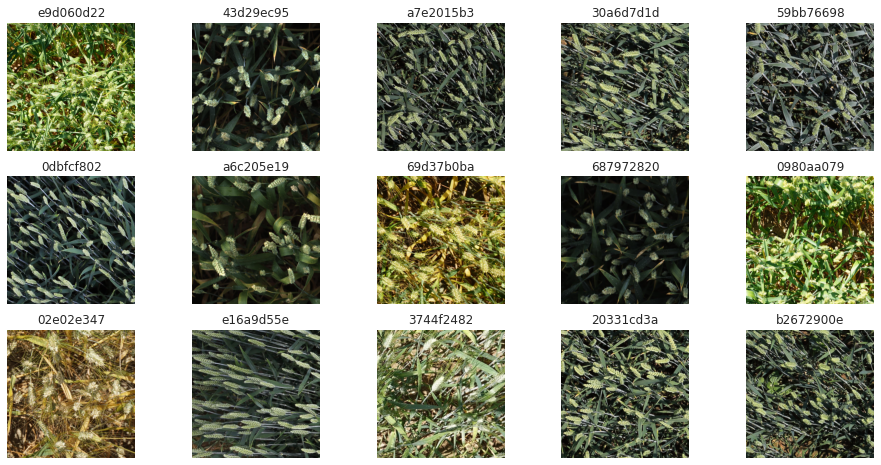

In [161]:
show_images(train_df.sample(n=15)['image_id'].values)

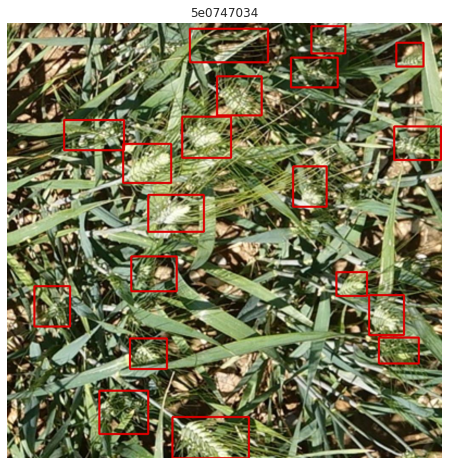

In [162]:
show_image_bb(train_df[train_df['image_id'] == '5e0747034'])

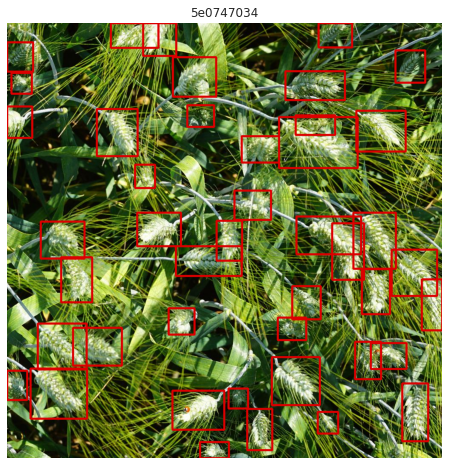

In [163]:
show_image_bb(train_df[train_df['image_id'] == '5b13b8160'])

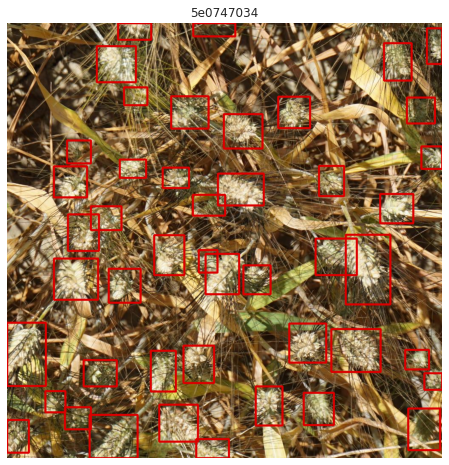

In [164]:
show_image_bb(train_df[train_df['image_id'] == '1f2b1a759'])